# Import Packages

In [1]:
import numpy as np
from math import atan2
import cv2
from matplotlib import pyplot as plt

# Finding Points

In [2]:
def shape_normalize(points, size=4):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    sk = MinMaxScaler().fit_transform(points)
    return (sk - 0.5)*size

In [3]:
a = np.array([[1,2,3]])
b = np.array([[4,5,6]])
c = np.concatenate([a, b], axis=0)
np.flip(c, axis=0)

array([[4, 5, 6],
       [1, 2, 3]])

In [4]:
def point_finder(image_path):

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    kernel_size = 5
    img = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    edges = cv2.Canny(img, 20,200)
    
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    points = []
    for c in contours[0]:
        points.append(c[0])
    points = np.array(points)
    
    normalized_points = np.array(shape_normalize(points, size=4))
#     normalized_points2 = np.array(shape_normalize(points, size=2))
#     normalized_points = np.array([normalized_points1[:, 0], normalized_points2[:, 1]]).T

    return normalized_points

In [5]:
def sample_points(points):
    sample_size = int(0.2 * points.shape[0])
    sample = np.zeros((sample_size, 2))
    np.random.seed(0)
    sample[:, 0] = np.random.choice(points[:, 0], size=sample_size)
    np.random.seed(0)
    sample[:, 1] = np.random.choice(points[:, 1], size=sample_size)
    return sample

In [6]:
def sample_points2(points, radius):
    sampled_points = []
    sampled_points.append(list(points[0]))
    for p in points[1:]:
        if np.sqrt((p[0]-sampled_points[-1][0])**2 + (p[1]-sampled_points[-1][1])**2) > radius:
            sampled_points.append(list(p))
    return sampled_points

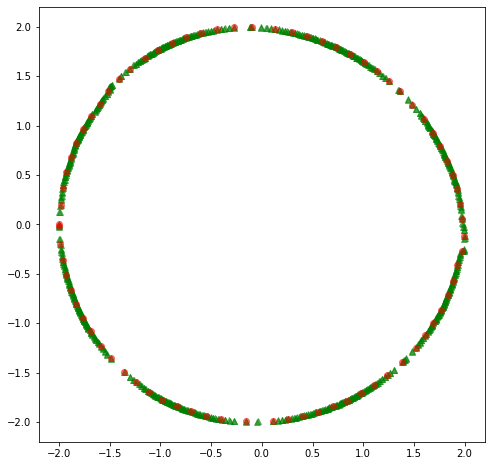

In [12]:
image_path = './images/circle_test.jpg'
pn = point_finder(image_path)
sample = sample_points2(pn, 0.15)
sample = np.array(sample)
plt.figure(figsize=(8, 8))
plt.scatter(list(pn[:, 1]), list(pn[:, 0]), alpha=0.5, marker='^', c='green')
plt.scatter(list(sample[:, 1]), list(sample[:, 0]), alpha=0.5, marker='o', c='red')

# Solving Inverse Kinematic Problem

In [8]:
def IKP(x, y, z):
    dp, ep, fp = 1.65, 3.3, 5.5
    db, eb = 6.5, 13
    U, L = 12, 34

    a = db - ep
    b = fp/2 - db*np.cos(np.pi/6)
    c = dp - db/2
    
    E1 = 2 * U * (y+a)
    E2 = -U * (2 * np.cos(np.pi/6) * (x + b) + y + c)
    E3 = U * (2 * np.cos(np.pi/6) * (x - b) - y - c)
    F1 = 2 * z * U
    F2 = F1
    F3 = F1
    G1 = x**2 + y**2 + z**2 + a**2 + U**2 + 2*y*a - L**2
    G2 = x**2 + y**2 + z**2 + b**2 + c**2 + U**2 + 2*(x*b - y*c) - L**2
    G3 = x**2 + y**2 + z**2 + b**2 + c**2 + U**2 - 2*(x*b + y*c) - L**2
    
    E = np.array([E1, E2, E3])
    F = np.array([F1, F2, F3])
    G = np.array([G1, G2, G3])
    
    T1 = (-F + np.sqrt(F**2 - G**2 + E**2))/(G-E)
    T2 = (-F - np.sqrt(F**2 - G**2 + E**2))/(G-E)
    C1, S1 = (1 - T1**2)/(1 + T1**2), 2*T1/(1 + T1**2)
    C2, S2 = (1 - T2**2)/(1 + T2**2), 2*T2/(1 + T2**2)     
    
    return np.array([np.round((atan2(S2[0], C2[0])*180/np.pi + 90)*22.75-947), \
        np.round((atan2(S2[1], C2[1])*180/np.pi + 90)*22.75-343), \
        np.round((atan2(S2[2], C2[2])*180/np.pi + 90)*22.75-343)])

In [9]:
print(IKP(0, 0, -25.84))
# change_operating_mode(position)
# goal_position(390, 1001, 1001)

[ 526. 1136. 1136.]


# Robot Connection & Command functions

In [10]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import time
import serial
position = 3
velocity = 1
# home_position = np.array([550,1160, 1160])
# home_position = np.array([390, 1001, 1001])
full_rotation = 4095
import os

if os.name == 'nt':
    import msvcrt
    def getch():
        return msvcrt.getch().decode()
else:
    import sys, tty, termios
    fd = sys.stdin.fileno()
    old_settings = termios.tcgetattr(fd)
    def getch():
        try:
            tty.setraw(sys.stdin.fileno())
            ch = sys.stdin.read(1)
        finally:
            termios.tcsetattr(fd, termios.TCSADRAIN, old_settings)
        return ch
      
      
from dynamixel_sdk import *                    # Uses Dynamixel SDK library


ADDR_TORQUE_ENABLE          = 64               # Control table address is different in Dynamixel model
ADDR_GOAL_POSITION          = 116
ADDR_GOAL_VELOCITY          = 104
ADDR_PRESENT_VELOCITY       = 128
ADDR_PRESENT_POSITION       = 132
ADDR_OPERATING_MODE         = 11

LEN_GOAL_POSITION       = 4
LEN_PRESENT_POSITION    = 4
LEN_GOAL_VELOCITY       = 4
LEN_PRESENT_VELOCITY    = 4


# Protocol version
PROTOCOL_VERSION            = 2.0               # See which protocol version is used in the Dynamixel

# Default setting
DXL1_ID                     = 1            # Dynamixel#1 ID: 1
DXL2_ID                     = 2            # Dynamixel#2 ID: 2
DXL3_ID                     = 3            # Dynamixel#3 ID: 3
BAUDRATE                    = 57600        # Dynamixel default baudrate : 57600
DEVICENAME                  = 'COM3'    

TORQUE_ENABLE               = 1            # Value for enabling the torque
TORQUE_DISABLE              = 0            # Value for disabling the torque        
              
portHandler = PortHandler(DEVICENAME)
packetHandler = PacketHandler(PROTOCOL_VERSION)

#--------------Group sync read and write-------------#
GSR_Position = GroupSyncRead(portHandler, packetHandler, ADDR_PRESENT_POSITION, LEN_PRESENT_POSITION)
GSR_Velocity = GroupSyncRead(portHandler, packetHandler, ADDR_PRESENT_VELOCITY, LEN_PRESENT_VELOCITY)

GSW_Position = GroupSyncWrite(portHandler, packetHandler, ADDR_GOAL_POSITION, LEN_GOAL_POSITION)
GSW_Velocity = GroupSyncWrite(portHandler, packetHandler, ADDR_GOAL_VELOCITY, LEN_GOAL_VELOCITY)
#---------------------------------------------------#

if portHandler.openPort():
    print("Succeeded to open the port")
else:
    print("Failed to open the port")
    print("Press any key to terminate...")
    getch()
    quit()


if portHandler.setBaudRate(BAUDRATE):
    print("Succeeded to change the baudrate")
else:
    print("Failed to change the baudrate")
    print("Press any key to terminate...")
    getch()
    quit()
  
GSR_Position.addParam(DXL1_ID) 
GSR_Position.addParam(DXL2_ID) 
GSR_Position.addParam(DXL3_ID)  

GSR_Velocity.addParam(DXL1_ID)
GSR_Velocity.addParam(DXL2_ID)
GSR_Velocity.addParam(DXL3_ID)

def allocate(inp):
  return [DXL_LOBYTE(DXL_LOWORD(inp)), DXL_HIBYTE(DXL_LOWORD(inp)), DXL_LOBYTE(DXL_HIWORD(inp)), DXL_HIBYTE(DXL_HIWORD(inp))]

def goal_position(inp1,inp2,inp3):
  GSW_Position.addParam(DXL1_ID, allocate(inp1)) 
  GSW_Position.addParam(DXL2_ID, allocate(inp2))
  GSW_Position.addParam(DXL3_ID, allocate(inp3)) 
  GSW_Position.txPacket()
  GSW_Position.clearParam()
  
def read_position():
  GSR_Position.txRxPacket()
  s1 = GSR_Position.getData(DXL1_ID, ADDR_PRESENT_POSITION, LEN_PRESENT_POSITION)
  s2 = GSR_Position.getData(DXL2_ID, ADDR_PRESENT_POSITION, LEN_PRESENT_POSITION)
  s3 = GSR_Position.getData(DXL3_ID, ADDR_PRESENT_POSITION, LEN_PRESENT_POSITION)
  return s1 ,s2 ,s3
  
def goal_velocity(inp1,inp2,inp3):
  GSW_Velocity.addParam(DXL1_ID, allocate(inp1)) 
  GSW_Velocity.addParam(DXL2_ID, allocate(inp2))
  GSW_Velocity.addParam(DXL3_ID, allocate(inp3)) 
  GSW_Velocity.txPacket()
  GSW_Velocity.clearParam()
  
def read_velocity():
  GSR_Velocity.txRxPacket()
  s1 = GSR_Velocity.getData(DXL1_ID, ADDR_PRESENT_VELOCITY, LEN_PRESENT_VELOCITY)
  s2 = GSR_Velocity.getData(DXL2_ID, ADDR_PRESENT_VELOCITY, LEN_PRESENT_VELOCITY)
  s3 = GSR_Velocity.getData(DXL3_ID, ADDR_PRESENT_VELOCITY, LEN_PRESENT_VELOCITY)
  return s1 ,s2 ,s3
  
def torque_disabling(inp):
  packetHandler.write1ByteTxRx(portHandler, DXL1_ID, ADDR_TORQUE_ENABLE, inp)
  packetHandler.write1ByteTxRx(portHandler, DXL2_ID, ADDR_TORQUE_ENABLE, inp)
  packetHandler.write1ByteTxRx(portHandler, DXL3_ID, ADDR_TORQUE_ENABLE, inp)

def change_operating_mode(inp):
  torque_disabling(TORQUE_DISABLE)
  packetHandler.write1ByteTxRx(portHandler, DXL1_ID, ADDR_OPERATING_MODE, inp)
  packetHandler.write1ByteTxRx(portHandler, DXL2_ID, ADDR_OPERATING_MODE, inp)
  packetHandler.write1ByteTxRx(portHandler, DXL3_ID, ADDR_OPERATING_MODE, inp)
  torque_disabling(TORQUE_ENABLE)
  
def homing(home_position):
  change_operating_mode(position)
  goal_position(home_position[0],home_position[1],home_position[2])  


Succeeded to open the port
Succeeded to change the baudrate


# Show Current Position of the Robot

In [11]:
time.sleep(1)
read_position()

(744, 1381, 1446)

# Normalizer

In [12]:
def normalizer(arr, alpha):
    return np.round(alpha*(arr/(np.sum(np.abs(arr)))))
error =  [-80, -15, -5]
normalizer(error, 4)

array([-3., -1., -0.])

# straight line movement control

In [13]:
def go_to_pos(x, y, z, alpha=10, mode="velocity"):
    goal_pos = IKP(x, y, z).astype(int)
    print("goal  ",goal_pos)
    if mode == "velocity":
        curr_pos = np.array(read_position())
        print("curr   ",curr_pos)
        error = goal_pos - curr_pos
        g_vel = np.ones(1)
        while True:
            g_vel = normalizer(error, alpha).astype(int)
            print("vel   ",g_vel)
            goal_velocity(g_vel[0], g_vel[1], g_vel[2])
            curr_pos = np.array(read_position())
            print("curr   ",curr_pos)
            error = goal_pos - curr_pos
            if (np.sqrt(np.square(error).sum()) < 30) or (np.sum(g_vel == 0) == 3):
                break
        print("-----------------loop end")
    else:
        goal_position(goal_pos[0], goal_pos[1], goal_pos[2])

In [14]:
def go_to_pos2(prev_goal, next_goal, alpha=8):
    prev_goal_pos = IKP(prev_goal[0], prev_goal[1], prev_goal[2])
    goal_pos = IKP(next_goal[0], next_goal[1], next_goal[2])
    curr_pos = np.array(read_position())
    error1 = goal_pos - prev_goal_pos
    error2 = goal_pos - curr_pos
    error = 0.8 * error1 + 0.2 * error2
    g_vel = np.ones(1)
    while True:
        g_vel = normalizer(error, alpha).astype(int)
        goal_velocity(g_vel[0], g_vel[1], g_vel[2])
        curr_pos = np.array(read_position())
        error = goal_pos - curr_pos
        error = 0.2 * error + 0.8 * error1
        if (np.sqrt(np.square(error).sum()) < 20) or (np.sum(g_vel == 0) == 3):
            break
    print("-----------------loop end")

# Test

In [15]:
def draw_shape(image_path):
    hp = [0, 0, -24.8]
    drawing_z = -25.84
    points = point_finder(image_path)
    sampled_points = sample_points2(points, 0.12)
    homing(IKP(hp[0], hp[1], hp[2]).astype(int))
    time.sleep(2.5)
    go_to_pos(sampled_points[0][0], sampled_points[0][1], hp[2], mode="position")
    time.sleep(2.5)
    go_to_pos(sampled_points[0][0], sampled_points[0][1], drawing_z + 0.34, mode="position")
    time.sleep(2.5)
    change_operating_mode(velocity)
    for point in sampled_points[1:]:
        print("point: ", point[0], point[1])
        go_to_pos(point[0], point[1], drawing_z)
        goal_velocity(0, 0, 0)
    go_to_pos(sampled_points[0][0], sampled_points[0][1], drawing_z)
    goal_velocity(0, 0, 0)

In [16]:
draw_shape('./images/ajib.jpg')
# draw_shape('./images/motavazi.jpg')
# draw_shape('./images/plus.jpg')


goal   [ 229  898 1159]
goal   [ 352 1020 1265]
point:  0.037735849056603765 -1.981264637002342
goal   [ 399 1182 1186]
curr    [ 405 1060 1287]
vel    [ 0  5 -4]
curr    [ 405 1059 1287]
vel    [ 0  5 -4]
curr    [ 405 1059 1287]
vel    [ 0  5 -4]
curr    [ 406 1060 1287]
vel    [ 0  5 -4]
curr    [ 405 1060 1287]
vel    [ 0  5 -4]
curr    [ 406 1060 1287]
vel    [ 0  5 -4]
curr    [ 405 1061 1287]
vel    [ 0  5 -4]
curr    [ 405 1061 1286]
vel    [ 0  5 -4]
curr    [ 405 1062 1287]
vel    [ 0  5 -4]
curr    [ 406 1062 1286]
vel    [ 0  5 -4]
curr    [ 406 1062 1286]
vel    [ 0  5 -4]
curr    [ 405 1063 1286]
vel    [ 0  5 -4]
curr    [ 406 1065 1286]
vel    [ 0  5 -4]
curr    [ 406 1066 1286]
vel    [ 0  5 -4]
curr    [ 406 1068 1286]
vel    [ 0  5 -5]
curr    [ 406 1068 1286]
vel    [ 0  5 -5]
curr    [ 406 1069 1286]
vel    [ 0  5 -5]
curr    [ 406 1069 1286]
vel    [ 0  5 -5]
curr    [ 406 1070 1285]
vel    [ 0  5 -5]
curr    [ 406 1071 1285]
vel    [ 0  5 -5]
curr    [ 406 1073 1

curr    [ 500 1287 1013]
vel    [ 5 -3  2]
curr    [ 503 1286 1013]
vel    [ 4 -3  3]
curr    [ 506 1285 1013]
vel    [ 4 -3  3]
curr    [ 508 1285 1013]
vel    [ 4 -3  3]
curr    [ 511 1284 1013]
-----------------loop end
point:  -1.9664570230607965 0.5011709601873537
goal   [ 571 1256 1019]
curr    [ 513 1283 1013]
vel    [ 6 -3  1]
curr    [ 515 1283 1013]
vel    [ 6 -3  1]
curr    [ 517 1282 1013]
vel    [ 6 -3  1]
curr    [ 519 1282 1013]
vel    [ 6 -3  1]
curr    [ 521 1281 1013]
vel    [ 6 -3  1]
curr    [ 524 1280 1013]
vel    [ 6 -3  1]
curr    [ 527 1280 1013]
vel    [ 6 -3  1]
curr    [ 530 1279 1013]
vel    [ 6 -3  1]
curr    [ 533 1278 1013]
vel    [ 6 -3  1]
curr    [ 535 1278 1013]
vel    [ 6 -3  1]
curr    [ 538 1277 1012]
vel    [ 5 -3  1]
curr    [ 540 1276 1013]
vel    [ 5 -4  1]
curr    [ 543 1275 1012]
vel    [ 5 -4  1]
curr    [ 544 1275 1013]
vel    [ 5 -4  1]
curr    [ 546 1274 1013]
vel    [ 5 -4  1]
curr    [ 549 1274 1012]
-----------------loop end
point:  -1

curr    [ 549 1160 1093]
vel    [-5  5  0]
curr    [ 549 1160 1093]
vel    [-5  5  0]
curr    [ 549 1161 1093]
vel    [-5  5  0]
curr    [ 547 1161 1093]
vel    [-5  5  0]
curr    [ 546 1162 1094]
vel    [-5  5  0]
curr    [ 546 1163 1093]
vel    [-5  5  0]
curr    [ 545 1164 1093]
-----------------loop end
point:  -0.649895178197065 -0.10772833723653408
goal   [ 520 1179 1100]
curr    [ 545 1164 1093]
vel    [-5  3  1]
curr    [ 545 1164 1093]
-----------------loop end
point:  -0.5324947589098532 -0.15456674473067933
goal   [ 516 1172 1108]
curr    [ 545 1165 1093]
vel    [-6  1  3]
curr    [ 543 1165 1093]
vel    [-6  1  3]
curr    [ 542 1166 1094]
vel    [-6  1  3]
curr    [ 542 1166 1094]
vel    [-6  1  3]
curr    [ 539 1168 1098]
-----------------loop end
point:  -0.4234800838574424 -0.21077283372365363
goal   [ 512 1167 1115]
curr    [ 536 1171 1100]
vel    [-6 -1  3]
curr    [ 533 1173 1102]
-----------------loop end
point:  -0.3060796645702304 -0.2669789227166275
goal   [ 508 1

curr    [ 449 1050 1294]
vel    [-5  3  3]
curr    [ 447 1050 1295]
vel    [-5  3  3]
curr    [ 445 1050 1297]
vel    [-5  3  2]
curr    [ 443 1050 1298]
vel    [-5  3  2]
curr    [ 442 1050 1300]
vel    [-5  3  2]
curr    [ 441 1050 1301]
vel    [-5  3  2]
curr    [ 439 1050 1302]
vel    [-4  4  2]
curr    [ 437 1051 1303]
vel    [-4  4  2]
curr    [ 435 1050 1305]
-----------------loop end
goal   [ 408 1074 1314]
curr    [ 433 1050 1306]
vel    [-4  4  1]
curr    [ 432 1050 1307]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1050 1308]
vel    [-4  4  1]
curr    [ 432 1051 1308]
vel    [-5  4  1]
curr    [ 428 1052 1309]
vel    [-4  5  1]
curr    [ 424 1053 1312]
-----------------loop end


# highest_possible = (800, 1400, 1400)